# Retail Sector Domain Analysis - Timeseries using RFM

## Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import xlrd
import pandas as pd
import datetime
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

## loading data

In [2]:
retail = pd.read_excel('Retail-Ecommerce.xlsx', dtype= {'CustomerID': str})  
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0  536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1  536365.0   71053.0                  WHITE METAL LANTERN       6.0   
2  536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3  536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4  536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom

Copying Data

In [3]:
#copy
data = retail.copy()

Checking shape of data

In [4]:
data.shape

(541909, 8)

### null values

In [5]:
#checking for the null values
data.isnull().sum()/data.shape[0]*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

#### Droping Null values

In [6]:
# first drop the rows where the description is null
data.dropna(axis = 0, subset = ["Description"], inplace = True)

In [7]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133626
Country             0
dtype: int64

In [8]:
#checking the data before droping these customer ID's
data[data["CustomerID"].isnull()]

InvoiceNo StockCode                      Description  Quantity  \
1443    536544.0   21773.0  DECORATIVE ROSE BATHROOM BOTTLE       1.0   
1444    536544.0   21774.0  DECORATIVE CATS BATHROOM BOTTLE       2.0   
1445    536544.0   21786.0               POLKADOT RAIN HAT        4.0   
1446    536544.0   21787.0            RAIN PONCHO RETROSPOT       2.0   
1447    536544.0   21790.0               VINTAGE SNAP CARDS       9.0   
...          ...       ...                              ...       ...   
541536  581498.0    85099B          JUMBO BAG RED RETROSPOT       5.0   
541537  581498.0    85099C   JUMBO  BAG BAROQUE BLACK WHITE       4.0   
541538  581498.0   85150.0    LADIES & GENTLEMEN METAL SIGN       1.0   
541539  581498.0   85174.0                S/4 CACTI CANDLES       1.0   
541540  581498.0       DOT                   DOTCOM POSTAGE       1.0   

               InvoiceDate  UnitPrice CustomerID         Country  
1443   2010-12-01 14:32:00       2.51        NaN  United Kingdom  
1444   2010-12-01 14:32:00       2.51        NaN  United Kingdom  
1445   2010-12-01 14:32:00       0.85        NaN  United Kingdom  
1446   2010-12-01 14:32:00       1.66        NaN  United Kingdom  
1447   2010-12-01 14:32:00       1.66        NaN  United Kingdom  
...                    ...        ...        ...             ...  
541536 2011-12-09 10:26:00       4.13        NaN  United Kingdom  
541537 2011-12-09 10:26:00       4.13        NaN  United Kingdom  
541538 2011-12-09 10:26:00       4.96        NaN  United Kingdom  
541539 2011-12-09 10:26:00      10.79        NaN  United Kingdom  
541540 2011-12-09 10:26:00    1714.17        NaN  United Kingdom  

[133626 rows x 8 columns]

In [9]:
data.iloc[575:, :]

InvoiceNo StockCode                        Description  Quantity  \
575     536412.0   22144.0     CHRISTMAS CRAFT LITTLE FRIENDS       2.0   
576     536412.0   22243.0  5 HOOK HANGER RED MAGIC TOADSTOOL       3.0   
577     536412.0   22077.0             6 RIBBONS RUSTIC CHARM       7.0   
578     536412.0   21448.0          12 DAISY PEGS IN WOOD BOX       1.0   
579     536412.0   22759.0       SET OF 3 NOTEBOOKS IN PARCEL       5.0   
...          ...       ...                                ...       ...   
541904  581587.0   22613.0        PACK OF 20 SPACEBOY NAPKINS      12.0   
541905  581587.0   22899.0       CHILDREN'S APRON DOLLY GIRL        6.0   
541906  581587.0   23254.0      CHILDRENS CUTLERY DOLLY GIRL        4.0   
541907  581587.0   23255.0    CHILDRENS CUTLERY CIRCUS PARADE       4.0   
541908  581587.0   22138.0      BAKING SET 9 PIECE RETROSPOT        3.0   

               InvoiceDate  UnitPrice CustomerID         Country  
575    2010-12-01 11:49:00       2.10    17920.0  United Kingdom  
576    2010-12-01 11:49:00       1.65    17920.0  United Kingdom  
577    2010-12-01 11:49:00       1.65    17920.0  United Kingdom  
578    2010-12-01 11:49:00       1.65    17920.0  United Kingdom  
579    2010-12-01 11:49:00       1.65    17920.0  United Kingdom  
...                    ...        ...        ...             ...  
541904 2011-12-09 12:50:00       0.85    12680.0          France  
541905 2011-12-09 12:50:00       2.10    12680.0          France  
541906 2011-12-09 12:50:00       4.15    12680.0          France  
541907 2011-12-09 12:50:00       4.15    12680.0          France  
541908 2011-12-09 12:50:00       4.95    12680.0          France  

[539880 rows x 8 columns]

Dropping Null values of customer ID

In [10]:
data.dropna(axis = 0, subset = ["CustomerID"], inplace = True)

In [11]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Creating Temporary Data 

In [12]:
#creating the temporary data frame
temp_df = pd.DataFrame(data["Country"].value_counts()) 

In [13]:
temp_df.head(10)

Country
United Kingdom   361878
Germany            9495
France             8491
EIRE               7485
Spain              2533
Netherlands        2371
Belgium            2069
Switzerland        1877
Portugal           1480
Australia          1259

In [14]:
names  = temp_df.index

#### Scatter plot: Temporary Data

In [15]:
px.scatter(temp_df, y = "Country", color = names) #checking for the occurence of most countries in our data

As you can see the United Kingdom has the max transcations as compared to other countries. The one here to note is that the "United Kingdom" is the dominating class in this data which making our data looks kinda imbalanced between major class and the minority class.

You can cross check the same after de-selecting the United Kingdom from the above chart and see how your axis transforms.


### Grouping Country and Quantity

In [16]:
#Now let's check the total quantity and by country
data.groupby("Country").sum()["Quantity"].sort_values(ascending = False).head(10)
#data.groupby("Country").sum()["Quantity"].sort_values(ascending = False).tail(10)

Country
United Kingdom    4008533.0
Netherlands        200128.0
EIRE               136329.0
Germany            117448.0
France             109848.0
Australia           83653.0
Sweden              35637.0
Switzerland         29778.0
Spain               26824.0
Japan               25218.0
Name: Quantity, dtype: float64

#### Scatter plot: Average price by Contries

In [17]:
#checking for the average price by country
px.scatter(data.iloc[:, [5, 7]].groupby(["Country"]).mean(), 
           y = "UnitPrice", size = "UnitPrice", title = "Average Price by Counties", opacity = 0.48)

From the above dot plot we can conclude that the Singapore has the highest averge price followed by the Norway and Malta. Let's go deeper and see the distribution to better understand about our data.`

### Extracting Unique Values of country

In [18]:
 #extracting unique country names
countries = data["Country"].unique()

#### Violin Plot: countries

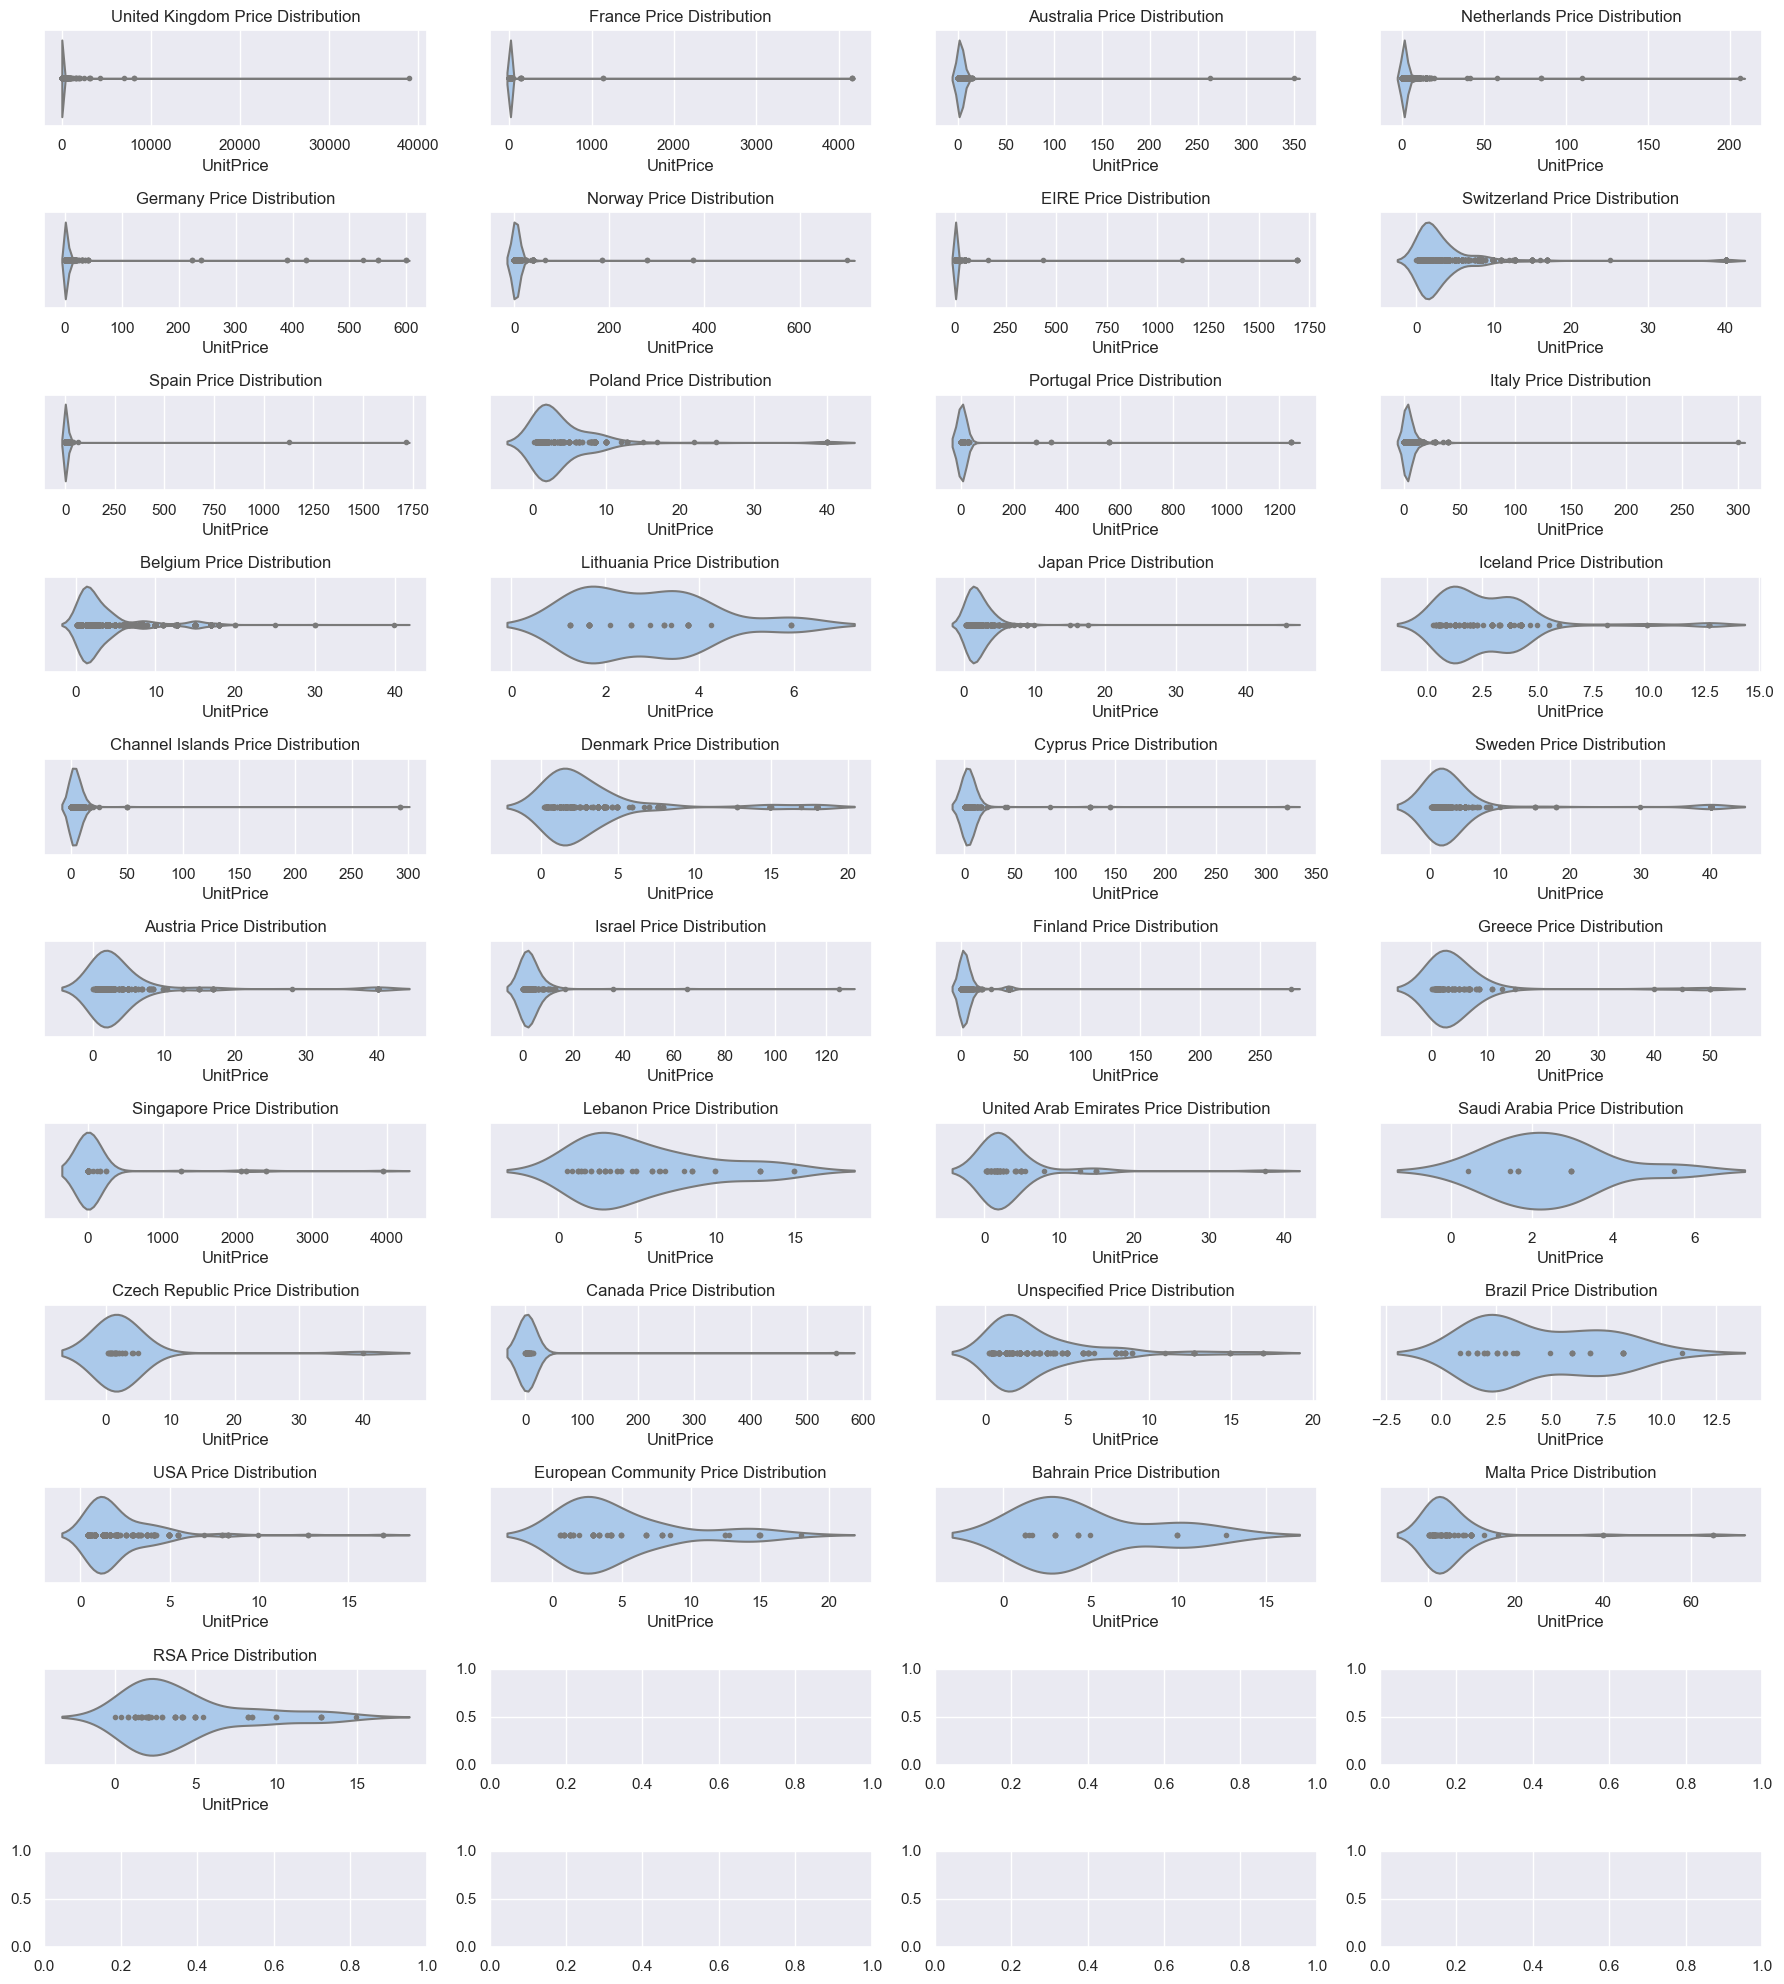

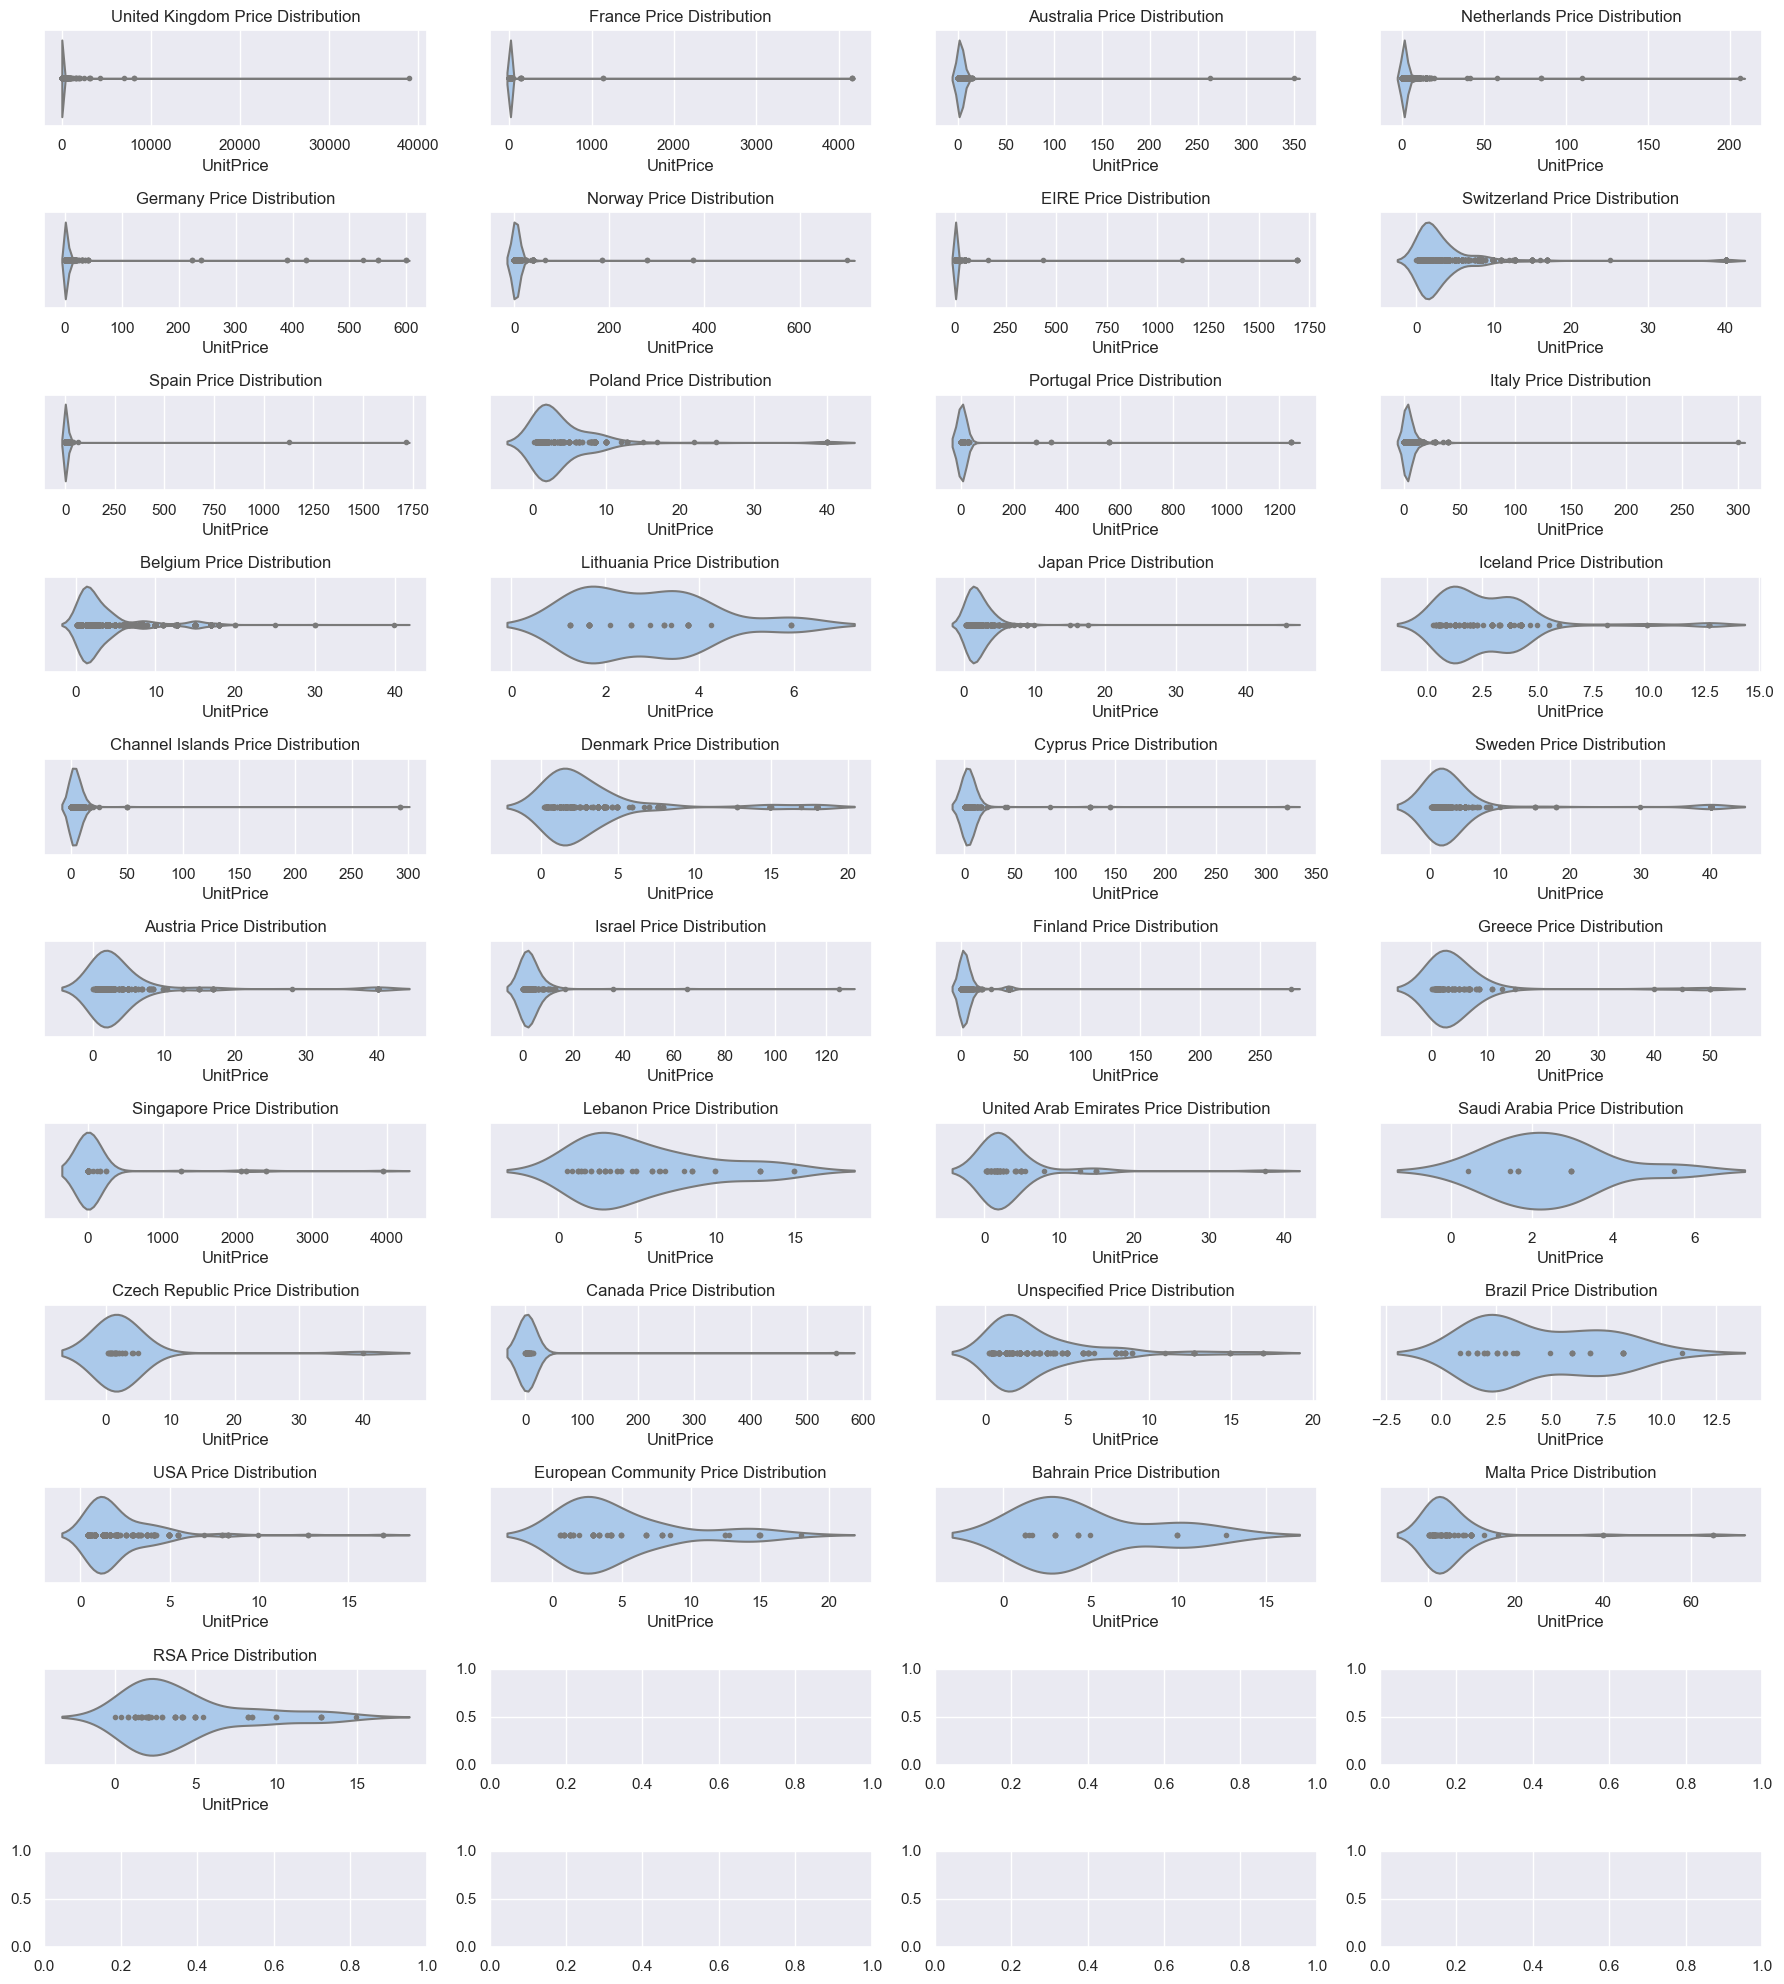

In [23]:
#plotting the violin plot for the data
fig, ax = plt.subplots(11, 4, figsize=(18,20))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i, c in enumerate(countries):
    sns.violinplot(x = "UnitPrice", data = data[data["Country"] == c], ax = axes_[i], inner = "point", palette = "pastel")
    axes_[i].set_title(c + ' ' + "Price Distribution")
    plt.tight_layout()
plt.show()

From the above plot what I can interpret is that most of the data is pretty skewed and there is lot's of high extreme values that are present in the data.

In [24]:
#Total Number of Unique Invoices 
len(data["InvoiceNo"].unique())

22190

### Creating Temporary data on Invoice

In [25]:
temp_invoice_df = data.groupby("InvoiceNo").sum()

In [26]:
temp_invoice_df.reset_index(inplace = True)

In [27]:
#Below are the top 30 invoices with total quantity purchased by them
temp_invoice_df.sort_values(by = "Quantity", ascending = False).head(30).iloc[:,:2].style.background_gradient(cmap = "Blues")

In [28]:
#Top 15 Invoices with average prices sorted from high to low
data.groupby(["InvoiceNo"]).mean().head(15).iloc[:, [1]].sort_values("UnitPrice", ascending = False)

UnitPrice
InvoiceNo           
536374.0   10.950000
536369.0    5.950000
536367.0    4.853333
536368.0    4.775000
536365.0    3.910000
536373.0    3.319375
536375.0    3.319375
536376.0    3.000000
536370.0    2.764500
536371.0    2.550000
536366.0    1.850000
536372.0    1.850000
536377.0    1.850000
536378.0    1.755263
536380.0    1.450000

I have grouped the data by Invoice to see the average spend by Invoice Number. Here one thing interesting to see that the invoice with number 536374 & 536369 has outspent others. So to gain some better clarity, let's check these 2 invoices and get insights on how much quantity they have purchased so far.

In [29]:
data[(data["InvoiceNo"] == 536374) | (data["InvoiceNo"] == 536369)]

InvoiceNo StockCode                 Description  Quantity  \
25  536369.0   21756.0    BATH BUILDING BLOCK WORD       3.0   
65  536374.0   21258.0  VICTORIAN SEWING BOX LARGE      32.0   

           InvoiceDate  UnitPrice CustomerID         Country  
25 2010-12-01 08:35:00       5.95    13047.0  United Kingdom  
65 2010-12-01 09:09:00      10.95    15100.0  United Kingdom

#### INITIAL EDA INSIGHTS:

1) Most of the customers are from the United Kingdom followed by the Germany, EIRE & France.

2) If we check the average price sale by countries, what we have observed is that Singapore has the highest averge price sale followed by the Norway and Malta.

3) Most of the countries data is skewed when it comes to the Price feature with lots of higher extreme values.

4) There are total 22190 uniques purchased happend so far.

5) We have also observed some of the Invoices who have purchased most of the quantities within 1 year of span.

6) When it comes to the average spend there are 2 invoices with number 536374 and 536369 having the highest average spent but upon inspection we also found the average product purchase was only 1 which is from USA followed by Belgium.

In [30]:
#Let's look at the data once again & see what else insights we can get from the data itself
data.head(15)

InvoiceNo StockCode                          Description  Quantity  \
0   536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1   536365.0   71053.0                  WHITE METAL LANTERN       6.0   
2   536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3   536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4   536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   
5   536365.0   22752.0         SET 7 BABUSHKA NESTING BOXES       2.0   
6   536365.0   21730.0    GLASS STAR FROSTED T-LIGHT HOLDER       6.0   
7   536366.0   22633.0               HAND WARMER UNION JACK       6.0   
8   536366.0   22632.0            HAND WARMER RED POLKA DOT       6.0   
9   536367.0   84879.0        ASSORTED COLOUR BIRD ORNAMENT      32.0   
10  536367.0   22745.0           POPPY'S PLAYHOUSE BEDROOM        6.0   
11  536367.0   22748.0            POPPY'S PLAYHOUSE KITCHEN       6.0   
12  536367.0   22749.0    FELTCRAFT PRINCESS CHARLOTTE DOLL       8.0   
13  536367.0   22310.0              IVORY KNITTED MUG COSY        6.0   
14  536367.0   84969.0   BOX OF 6 ASSORTED COLOUR TEASPOONS       6.0   

           InvoiceDate  UnitPrice CustomerID         Country  
0  2010-12-01 08:26:00       2.55    17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75    17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
5  2010-12-01 08:26:00       7.65    17850.0  United Kingdom  
6  2010-12-01 08:26:00       4.25    17850.0  United Kingdom  
7  2010-12-01 08:28:00       1.85    17850.0  United Kingdom  
8  2010-12-01 08:28:00       1.85    17850.0  United Kingdom  
9  2010-12-01 08:34:00       1.69    13047.0  United Kingdom  
10 2010-12-01 08:34:00       2.10    13047.0  United Kingdom  
11 2010-12-01 08:34:00       2.10    13047.0  United Kingdom  
12 2010-12-01 08:34:00       3.75    13047.0  United Kingdom  
13 2010-12-01 08:34:00       1.65    13047.0  United Kingdom  
14 2010-12-01 08:34:00       4.25    13047.0  United Kingdom

## Exploratory Data Analysis

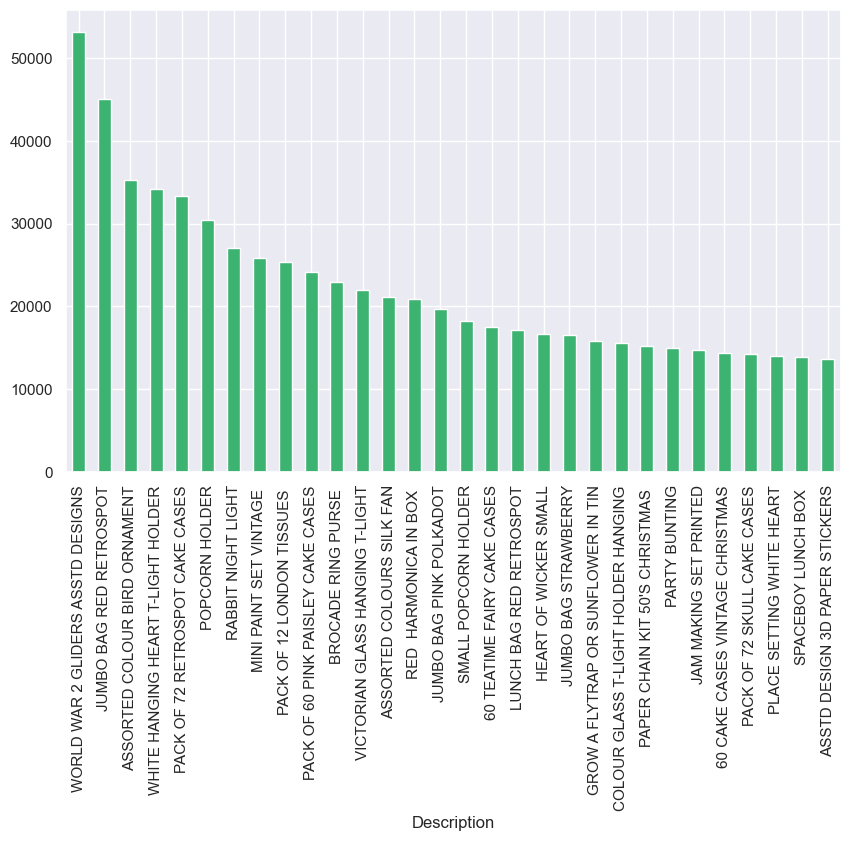

In [33]:
#Let's check which product has been purchased more often so far
plt.figure(figsize=(10,6))
data.groupby("Description").sum().sort_values(by = "Quantity", ascending = False).head(30)["Quantity"].plot(kind = "bar", color = 'mediumseagreen')
plt.show()

Copying Data

In [34]:
temp_data = data.copy()

In [35]:
temp_data

InvoiceNo StockCode                          Description  Quantity  \
0       536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1       536365.0   71053.0                  WHITE METAL LANTERN       6.0   
2       536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3       536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4       536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   
...          ...       ...                                  ...       ...   
541904  581587.0   22613.0          PACK OF 20 SPACEBOY NAPKINS      12.0   
541905  581587.0   22899.0         CHILDREN'S APRON DOLLY GIRL        6.0   
541906  581587.0   23254.0        CHILDRENS CUTLERY DOLLY GIRL        4.0   
541907  581587.0   23255.0      CHILDRENS CUTLERY CIRCUS PARADE       4.0   
541908  581587.0   22138.0        BAKING SET 9 PIECE RETROSPOT        3.0   

               InvoiceDate  UnitPrice CustomerID         Country  
0      2010-12-01 08:26:00       2.55    17850.0  United Kingdom  
1      2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
2      2010-12-01 08:26:00       2.75    17850.0  United Kingdom  
3      2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
4      2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
...                    ...        ...        ...             ...  
541904 2011-12-09 12:50:00       0.85    12680.0          France  
541905 2011-12-09 12:50:00       2.10    12680.0          France  
541906 2011-12-09 12:50:00       4.15    12680.0          France  
541907 2011-12-09 12:50:00       4.15    12680.0          France  
541908 2011-12-09 12:50:00       4.95    12680.0          France  

[406829 rows x 8 columns]

### Data Time Analysis

In [36]:
#Date Time Analysis
temp_data.loc[:, "Month"] = data.InvoiceDate.dt.month
temp_data.loc[:, "Time"] = data.InvoiceDate.dt.time
temp_data.loc[:, "Year"] = data.InvoiceDate.dt.year
temp_data.loc[:, "Day"] = data.InvoiceDate.dt.day
temp_data.loc[:, "Quarter"] = data.InvoiceDate.dt.quarter
temp_data.loc[:, "Day of Week"] = data.InvoiceDate.dt.dayofweek

#### Mapping days of week

In [37]:
#Mapping day of week
dayofweek_mapping = dict({0: "Monday", 
                         1: "Tuesday", 
                         2: "Wednesday" , 
                         3: "Thursday", 
                         4: "Friday", 
                         5: "Saturday", 
                         6: "Sunday"})

In [38]:
#renaming the data values using map function
temp_data["Day of Week"] = temp_data["Day of Week"].map(dayofweek_mapping)

In [39]:
temp_data

InvoiceNo StockCode                          Description  Quantity  \
0       536365.0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1       536365.0   71053.0                  WHITE METAL LANTERN       6.0   
2       536365.0    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3       536365.0    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4       536365.0    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   
...          ...       ...                                  ...       ...   
541904  581587.0   22613.0          PACK OF 20 SPACEBOY NAPKINS      12.0   
541905  581587.0   22899.0         CHILDREN'S APRON DOLLY GIRL        6.0   
541906  581587.0   23254.0        CHILDRENS CUTLERY DOLLY GIRL        4.0   
541907  581587.0   23255.0      CHILDRENS CUTLERY CIRCUS PARADE       4.0   
541908  581587.0   22138.0        BAKING SET 9 PIECE RETROSPOT        3.0   

               InvoiceDate  UnitPrice CustomerID         Country  Month  \
0      2010-12-01 08:26:00       2.55    17850.0  United Kingdom     12   
1      2010-12-01 08:26:00       3.39    17850.0  United Kingdom     12   
2      2010-12-01 08:26:00       2.75    17850.0  United Kingdom     12   
3      2010-12-01 08:26:00       3.39    17850.0  United Kingdom     12   
4      2010-12-01 08:26:00       3.39    17850.0  United Kingdom     12   
...                    ...        ...        ...             ...    ...   
541904 2011-12-09 12:50:00       0.85    12680.0          France     12   
541905 2011-12-09 12:50:00       2.10    12680.0          France     12   
541906 2011-12-09 12:50:00       4.15    12680.0          France     12   
541907 2011-12-09 12:50:00       4.15    12680.0          France     12   
541908 2011-12-09 12:50:00       4.95    12680.0          France     12   

            Time  Year  Day  Quarter Day of Week  
0       08:26:00  2010    1        4   Wednesday  
1       08:26:00  2010    1        4   Wednesday  
2       08:26:00  2010    1        4   Wednesday  
3       08:26:00  2010    1        4   Wednesday  
4       08:26:00  2010    1        4   Wednesday  
...          ...   ...  ...      ...         ...  
541904  12:50:00  2011    9        4      Friday  
541905  12:50:00  2011    9        4      Friday  
541906  12:50:00  2011    9        4      Friday  
541907  12:50:00  2011    9        4      Friday  
541908  12:50:00  2011    9        4      Friday  

[406829 rows x 14 columns]

### Visualization

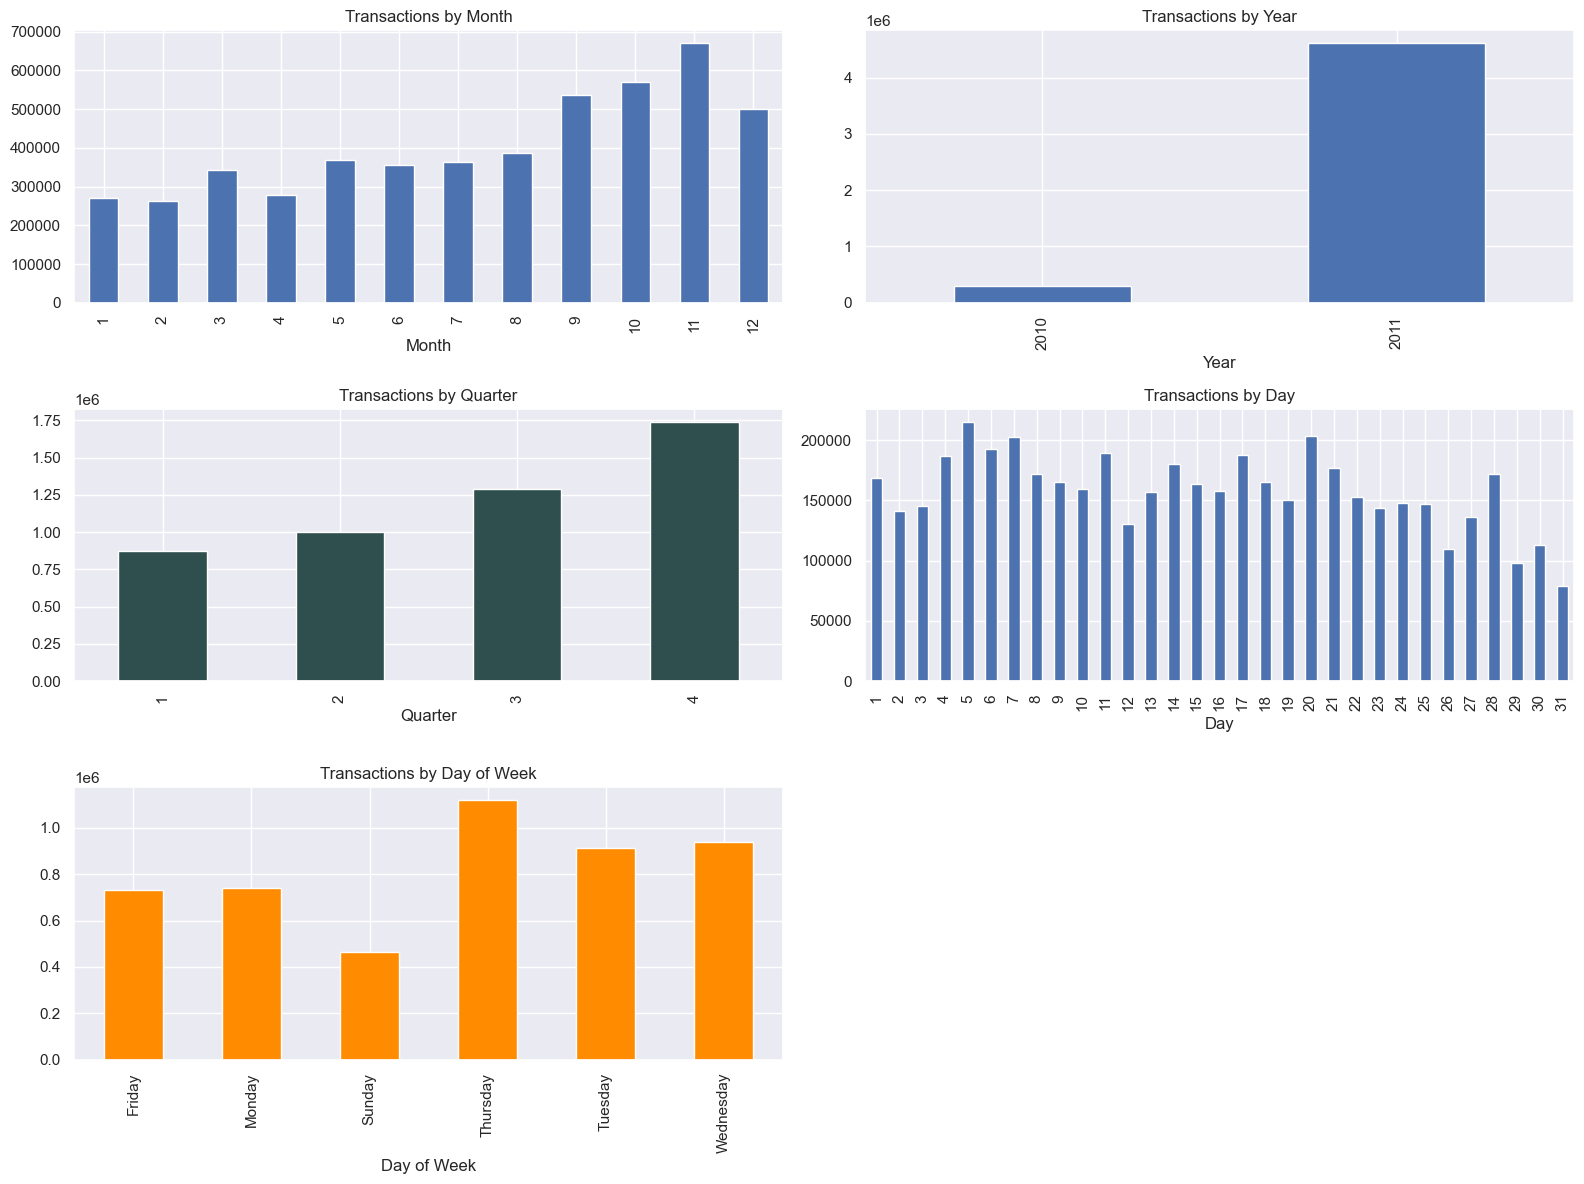

In [40]:
#Plotting the above data
plt.figure(figsize=(16,12))

plt.subplot(3,2,1)
temp_data.groupby("Month").sum()["Quantity"].plot(kind = "bar")
plt.title("Transactions by Month")

plt.subplot(3,2,2)
temp_data.groupby("Year").sum()["Quantity"].plot(kind = "bar")
plt.title("Transactions by Year")

plt.subplot(3,2,3)
temp_data.groupby("Quarter").sum()["Quantity"].plot(kind = "bar", color = "darkslategrey")
plt.title("Transactions by Quarter")

plt.subplot(3,2,4)
temp_data.groupby("Day").sum()["Quantity"].plot(kind = "bar")
#sns.lineplot(x = "Day", y = "Quantity", data = temp_data.groupby("Day").sum("Quantity"), marker = "o", )
#plt.axvline(7, color = 'r', linestyle = '--')
#plt.axvline(15, color = 'k', linestyle = "dotted")
plt.title("Transactions by Day")

plt.subplot(3,2,5)
temp_data.groupby("Day of Week").sum()["Quantity"].plot(kind = "bar", color = "darkorange")
plt.title("Transactions by Day of Week")
plt.tight_layout()
plt.show()

As we can see, in 2010 the transactions is quite low as compared to 2011. But as if now, we don't know the reason behind this so let's investigate why 2010 is low as compared to other.

In [41]:
print("Total Number of Countries in 2010: {}".format(len(temp_data[temp_data["Year"] == 2010]["Country"].unique())))
print("Total Number of Transactions in 2010: {}".format(temp_data[temp_data["Year"] == 2010]["Quantity"].sum()))
print("--------------------------------------------")
print("Total Number of Countries in 2011: {}".format(len(temp_data[temp_data["Year"] == 2011]["Country"].unique())))
print("Total Number of Transactions in 2011: {}".format(temp_data[temp_data["Year"] == 2011]["Quantity"].sum()))
print("--------------------------------------------")

Total Number of Countries in 2010: 23
Total Number of Transactions in 2010: 296362.0
--------------------------------------------
Total Number of Countries in 2011: 36
Total Number of Transactions in 2011: 4610526.0
--------------------------------------------


Through this analysis what conclusion we can make is that may be the company has started their operations in other countries and started to expand their business further

In [43]:
_2010 = temp_data[temp_data["Year"] == 2010]["Country"].unique()
_2011 = temp_data[temp_data["Year"] == 2011]["Country"].unique()

In [44]:
#checking for the countries which are available in  2010 but not in 2011.

no_cols = []

for i in (_2010):
    if i not in _2011:
        no_cols.append(i)
print("These are the values which are not present in 2009: {}".format(no_cols))

These are the values which are not present in 2009: ['Lithuania']


In [45]:
temp = data.groupby(["Country", "Description"]).sum()["Quantity"]

In [46]:
temp = pd.DataFrame(temp)

### Top 8 Countries With Popular Products

In [47]:
top_8_countries = ["United Kingdom", "Netherlands", "EIRE", "Denmark", "Germany", "France", "Australia", "Sweden"]

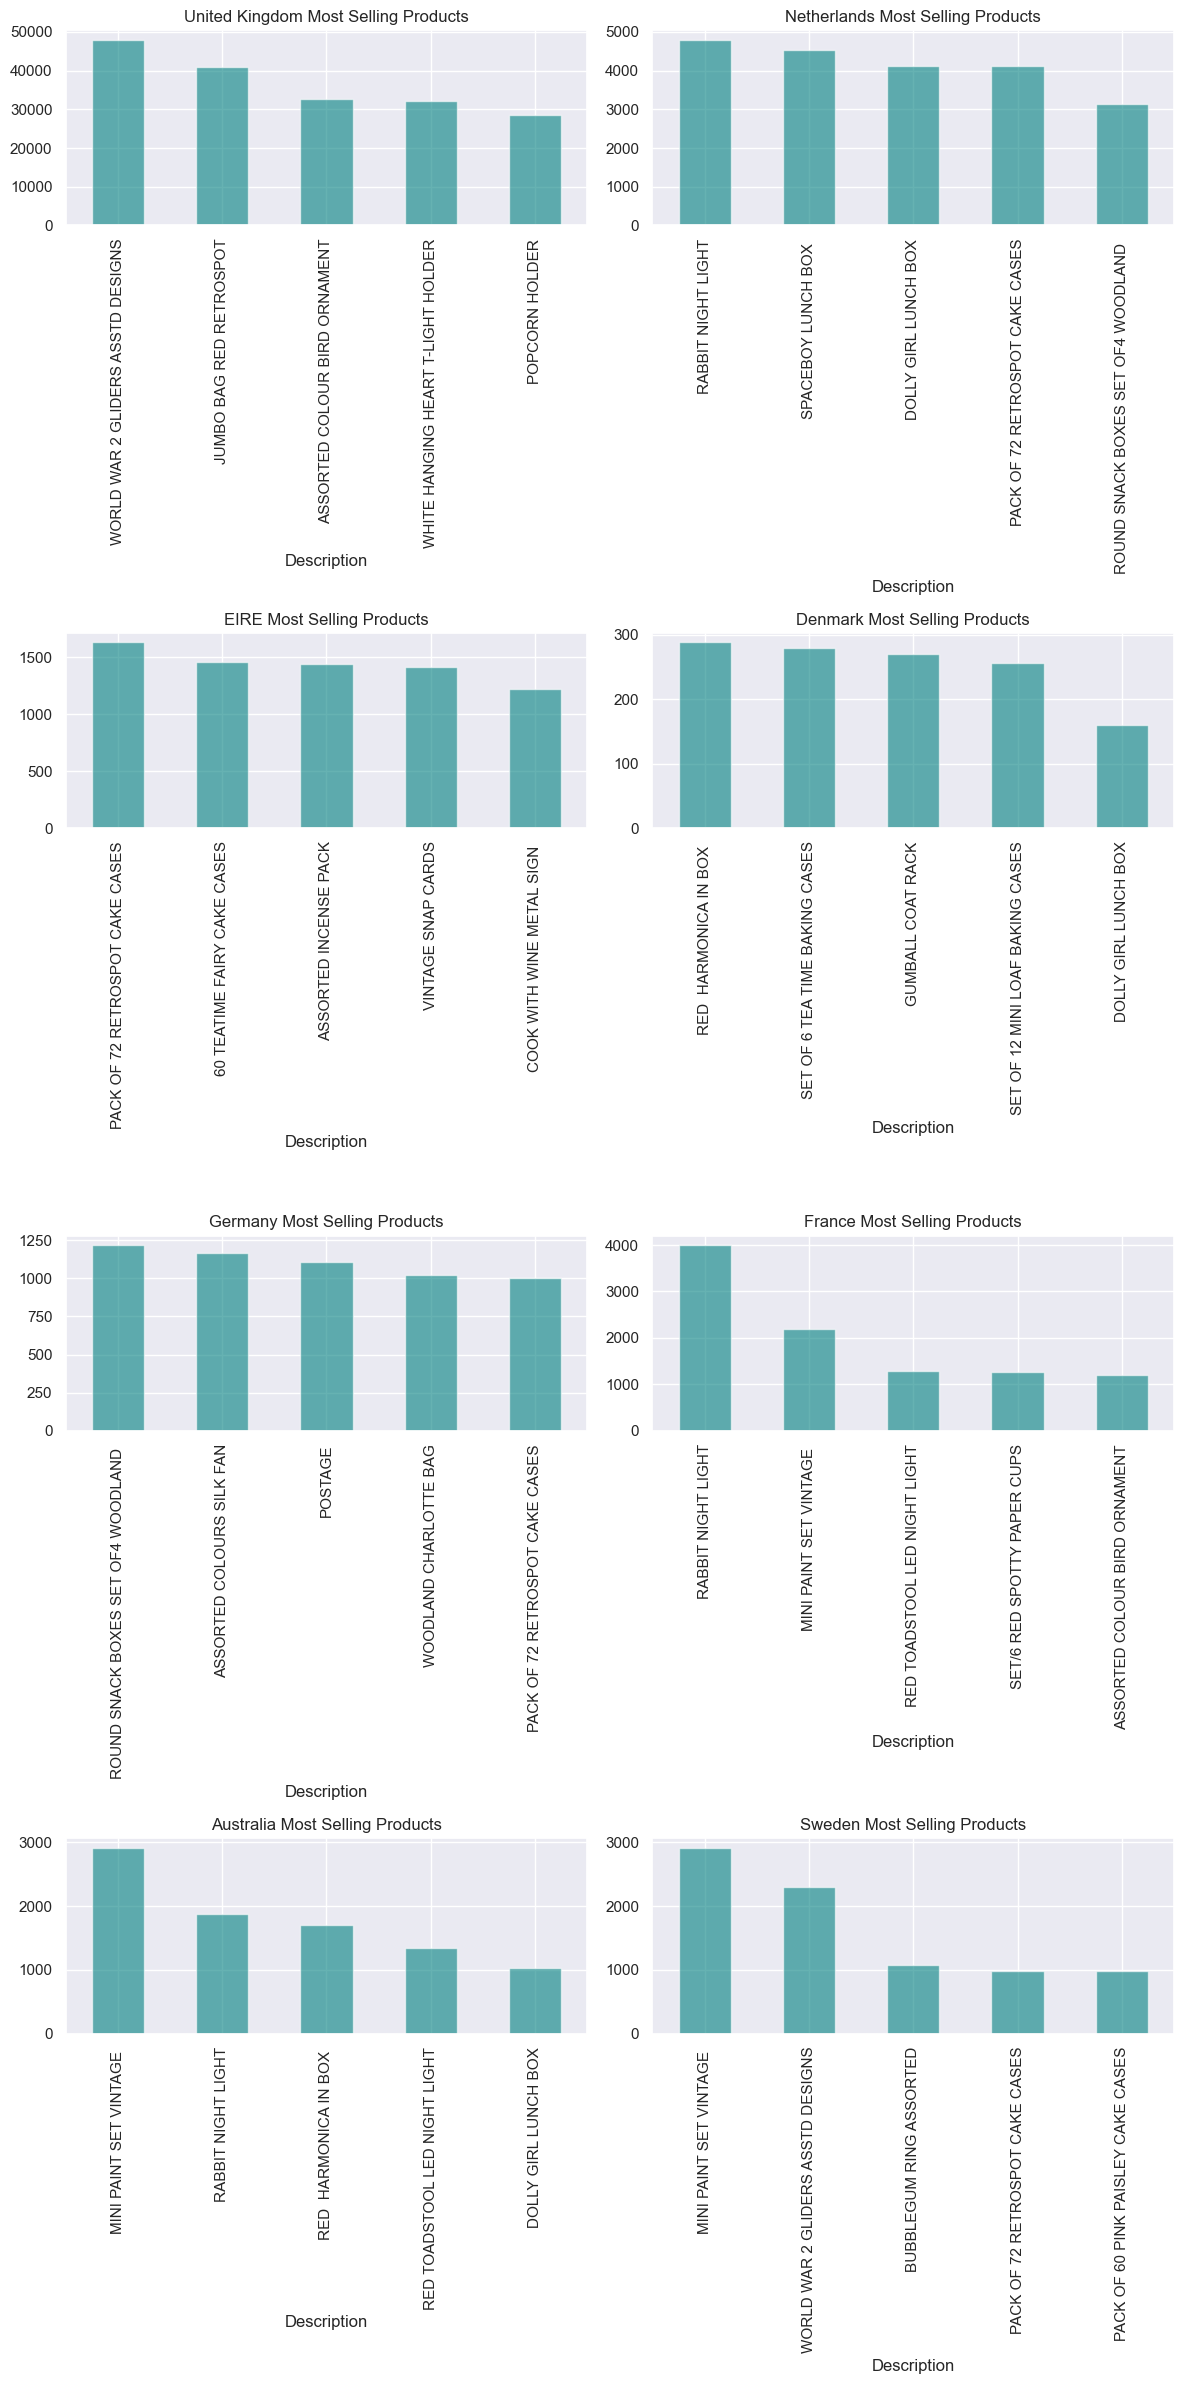

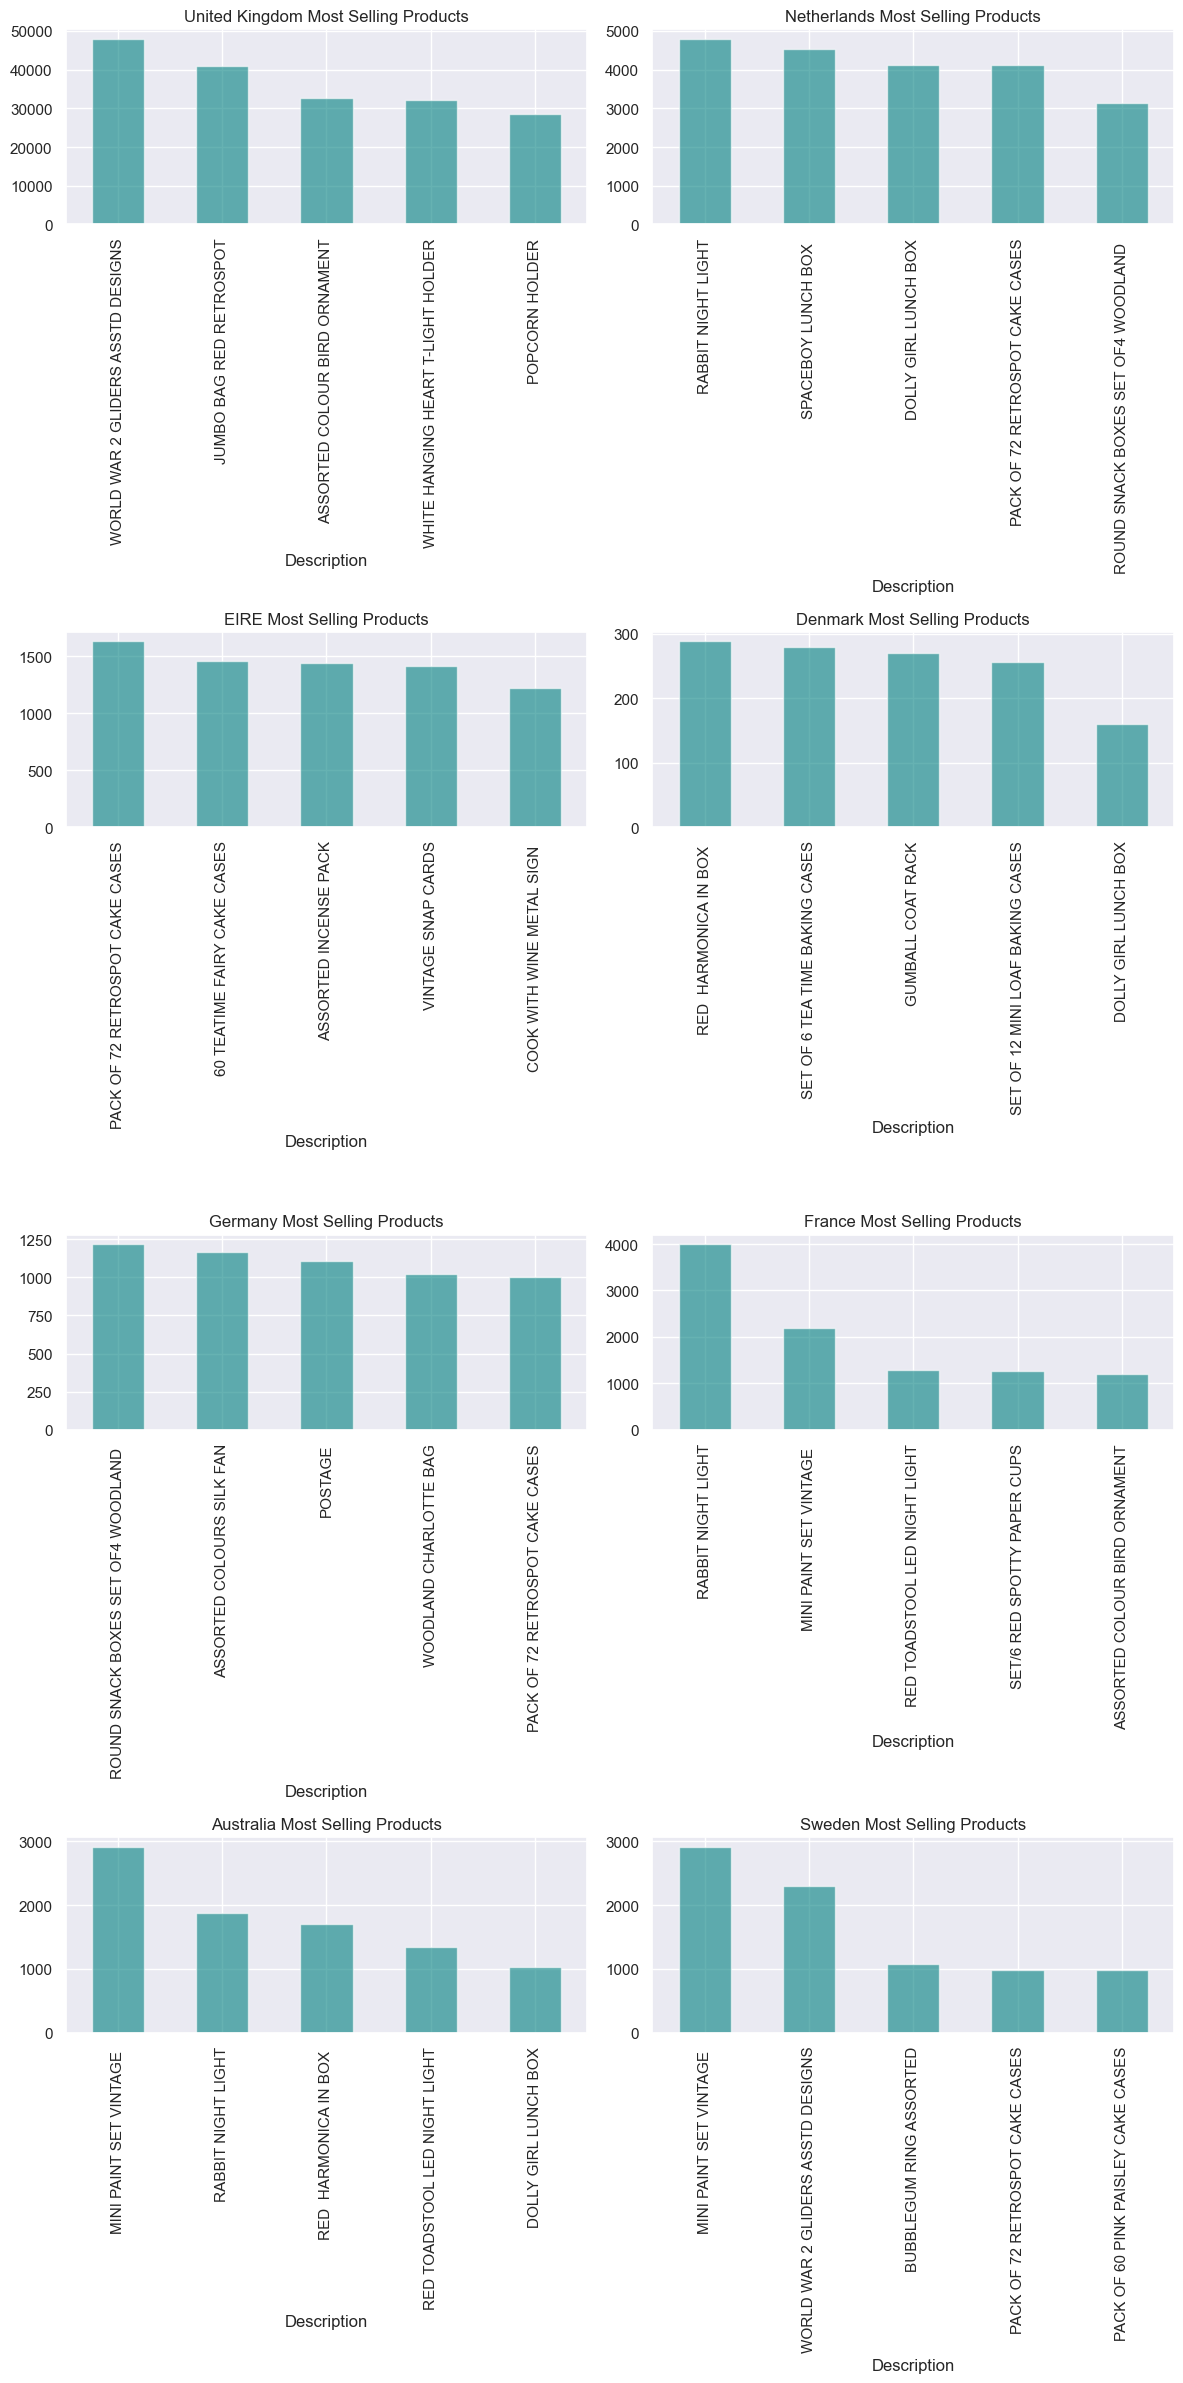

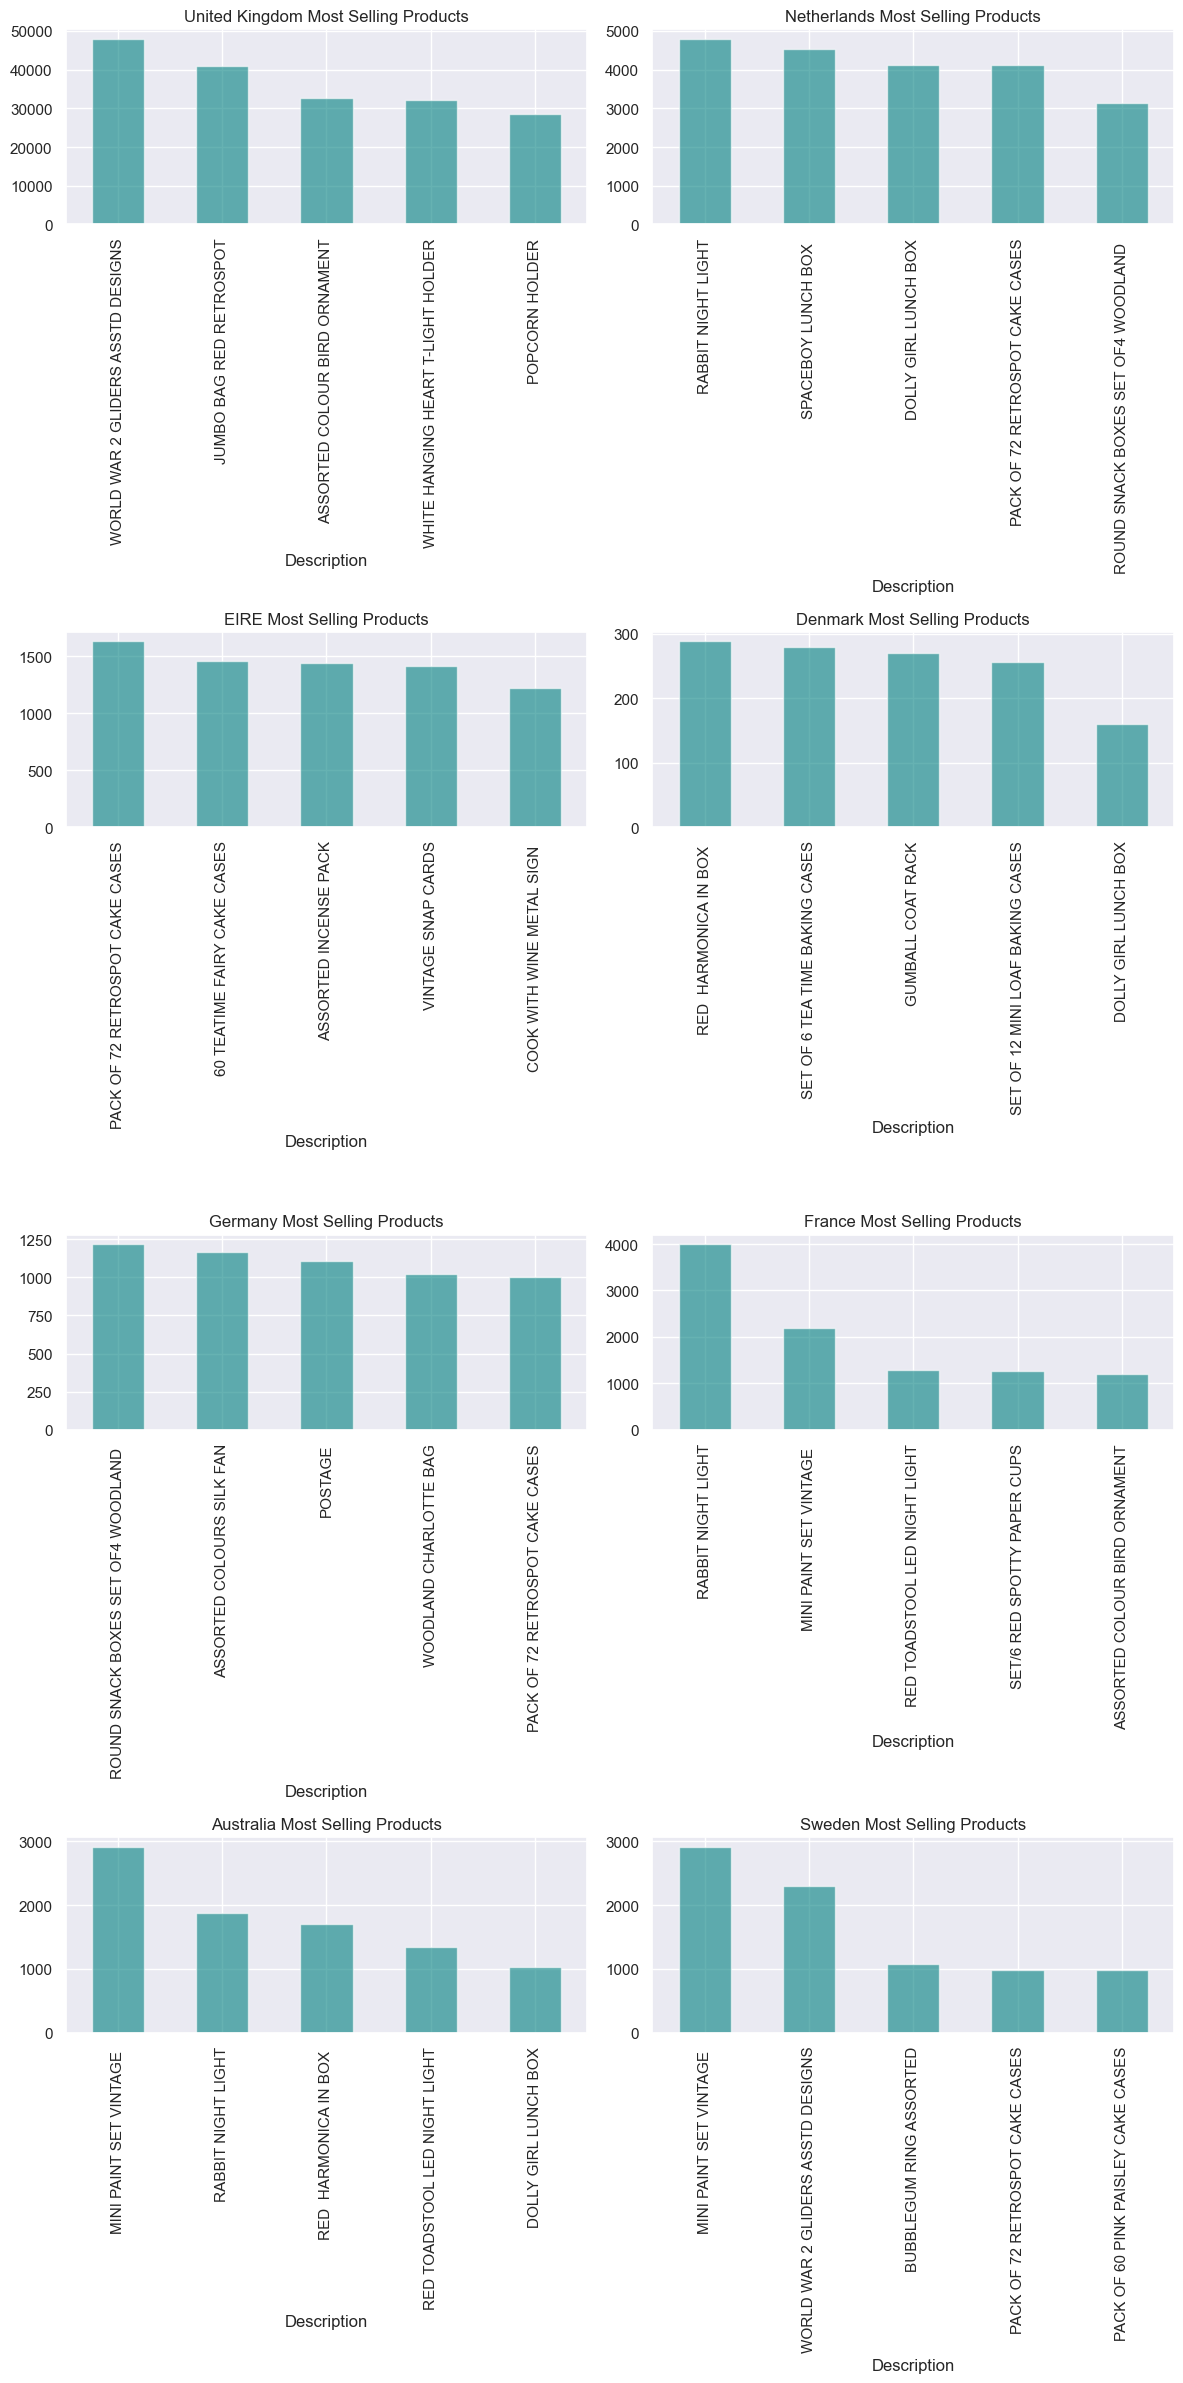

In [50]:
x = 1
plt.figure(figsize=(12,24))
for x, c in enumerate(top_8_countries):
    ax = plt.subplot(4,2, x+1)
    plt.title(c + ' '+ "Most Selling Products")
    temp.loc[c].sort_values(by = "Quantity", ascending = False)["Quantity"].head(5).plot(kind = "bar", ax = ax, color = "teal", alpha = 0.6)
    plt.tight_layout()
plt.show();

### Bottom 5 Countries with Mostly Purchased Products

In [51]:
least_5_country = ["Saudi Arabia", "Lebanon", "European Community", "Brazil", "Czech Republic"]

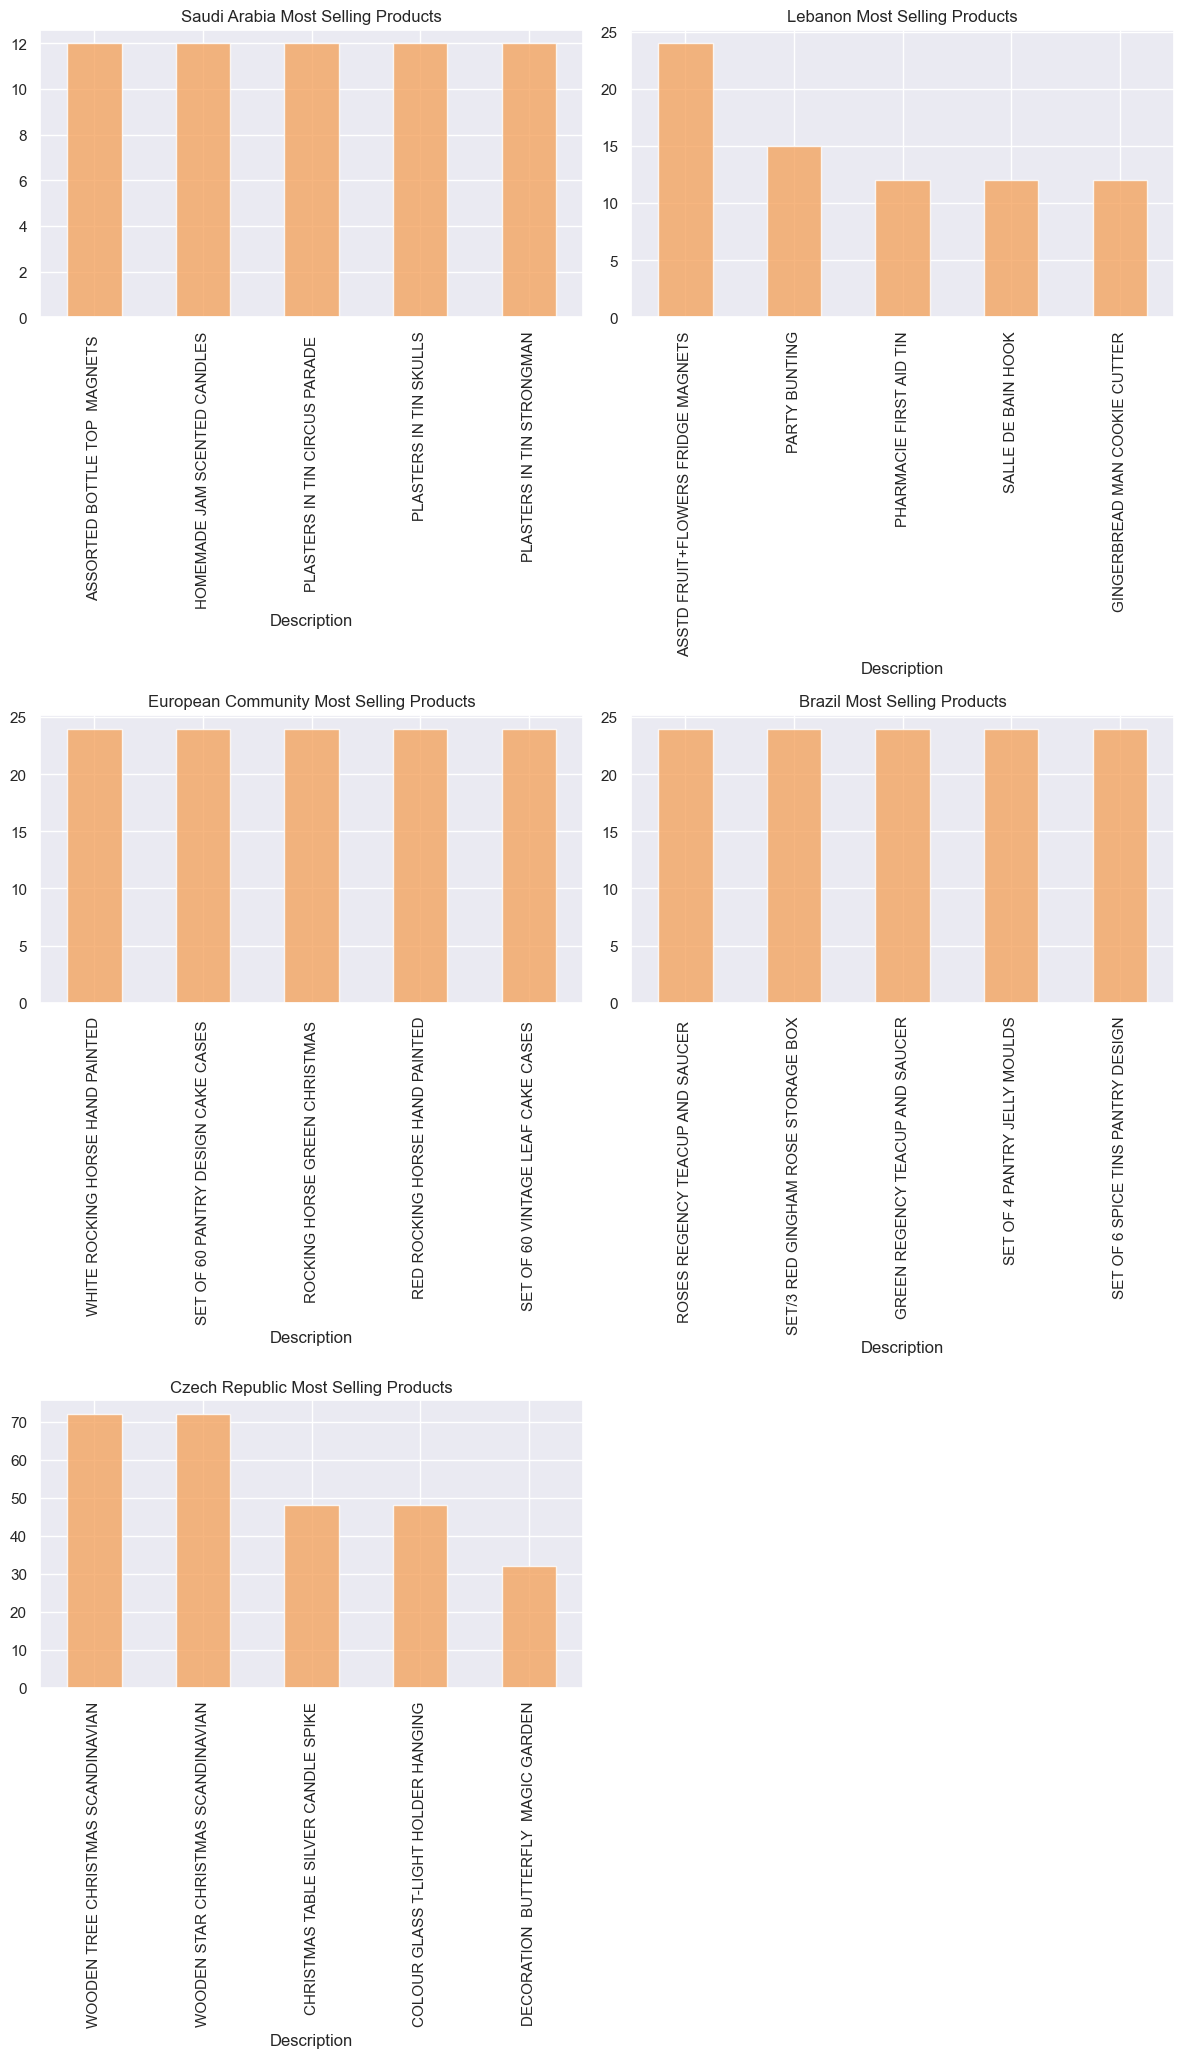

In [52]:
x = 1
plt.figure(figsize=(12,24))
for x, c in enumerate(least_5_country):
    ax = plt.subplot(4,2, x+1)
    plt.title(c + ' '+ "Most Selling Products")
    temp.loc[c].sort_values(by = "Quantity", ascending = False)["Quantity"].head(5).plot(kind = "bar", ax = ax, color = "sandybrown", alpha = 0.8)
    
    plt.tight_layout()
plt.show();

### EDA INSIGHTS:

1) Our Top 5 Best Selling Products are World War 2 Gliders, White Hanging Heart, Assorted Colour Bird, Jumbo Bag Red, popcorn holder.

2) Most Transactions happened in the month of Novemeber which is evident due to festive seasons.

3) 2011 is the year in which we have the most transactions followed by the 2010

4) Q4 being the highest when it comes transactions.

5) It also observed that in the end of the 1st week and starting of the 3rd week, people tends to buy more.

6) People loves to shop on Thursday followed by Tuesday and Wednesday.